This notebook evaluates speed calculation difference when keypoint predictions are perfect for object 1 and object 4 of our demo video.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from tqdm import tqdm
from sklearn import linear_model
import pandas as pd
from math import sqrt
import math
from PIL import Image


Object 1 range: 34- 90, object 3 range: 241 - 391

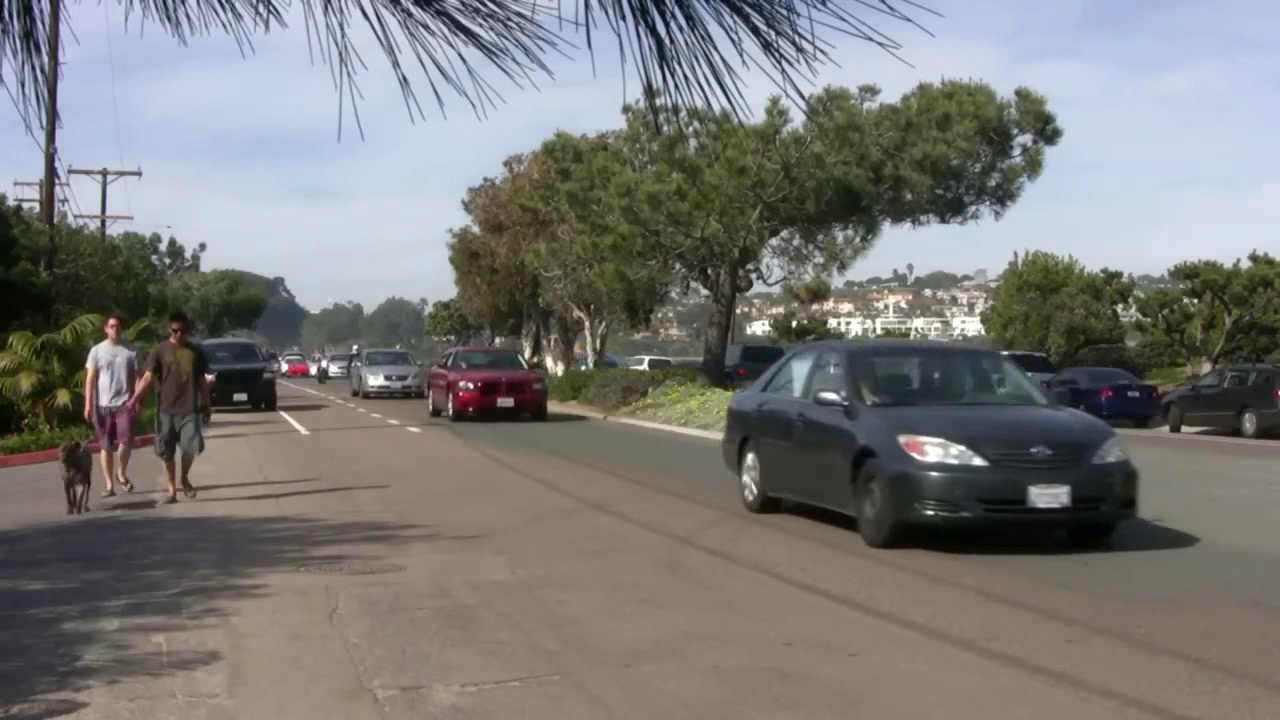

In [2]:
# Visualize object 1
im = Image.open("/code/data/datasets/common_hall/demo_imgs_upload/58.jpg")
im.show()

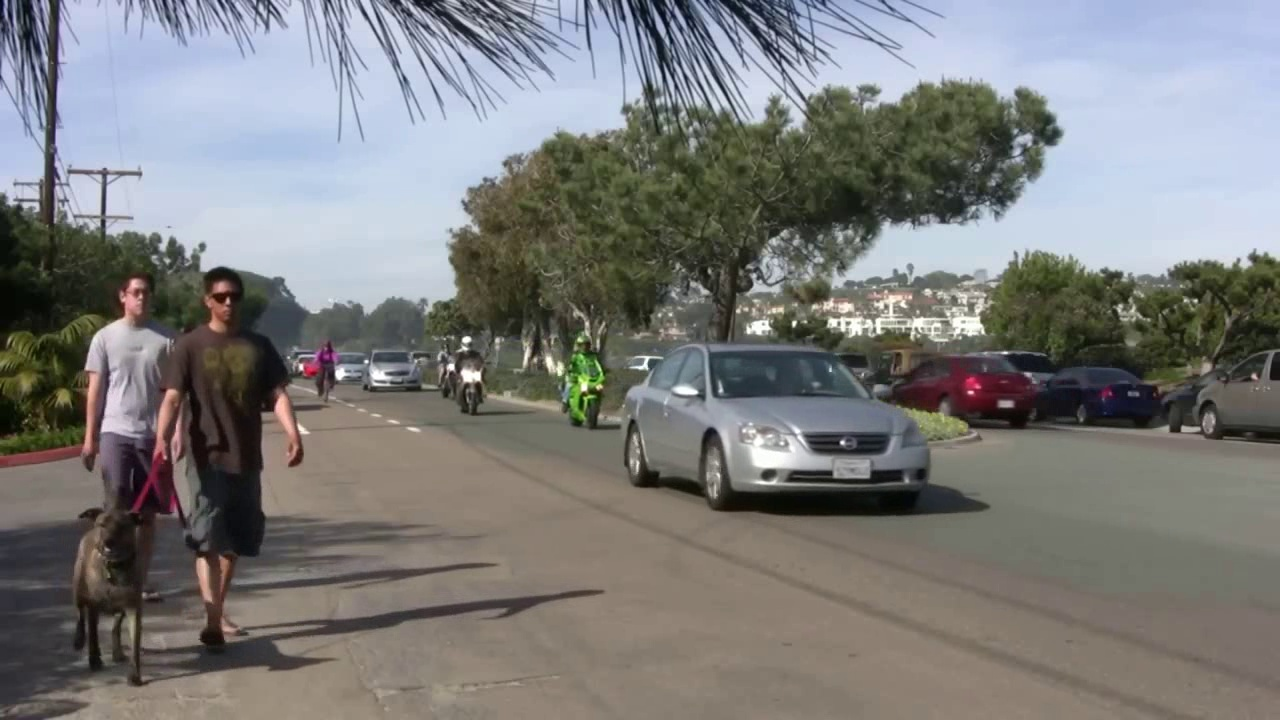

In [22]:

# Visualize object 2
im = Image.open("/code/data/datasets/common_hall/demo_imgs_upload/247.jpg")
im.show()

In [3]:
WHEEL_BASE = 2.43 #IN METERS
MPERSTOMPH = 2.237  # METERS PER SECOND TO MILES PER HOUR
FRAMESTOSEC = 0.033
DISTANCE_ERROR_THRESHOLD = 3
INBETWEENANGLE = 45


In [4]:
annotation_dir = '/root/.darwin/datasets/sparrow-computing/speed_eval/releases/v2/annotations'
annotations_list = os.listdir(annotation_dir)

In [5]:
def get_theta(_x1, _y1, _x2, _y2):
    return 90 - math.degrees(math.atan((_y2 - _y1)/(_x2 - _x1)))

In [6]:
def get_distance(x1, y1, x2, y2):
    return math.sqrt((x1-x2)**2 + (y1 -y2)**2)

In [7]:
def frames_to_seconds(_fps, _n_frames):
    return (1/_fps) * _n_frames

Following is the analysis for object 1.

In [8]:
front_tire_x_list = []
front_tire_y_list = []
back_tire_x_list = []
back_tire_y_list = []
object_start = 241
object_end = 391
# object_start = 34
# object_end = 90
for i in range(object_start, object_end):
    f = open(os.path.join(annotation_dir, f'{i}.json'))
    tires = json.load(f)
    if len(tires['annotations'])== 2:
        back_x = tires['annotations'][0]['keypoint']['x']
        back_y = tires['annotations'][0]['keypoint']['y']
        front_x = tires['annotations'][1]['keypoint']['x']
        front_y = tires['annotations'][1]['keypoint']['y']
        #
        front_tire_x_list.append(front_x)
        front_tire_y_list.append(front_y)
        back_tire_x_list.append(back_x)
        back_tire_y_list.append(back_y)
    if len(tires['annotations'])== 1:
        back_x = tires['annotations'][0]['keypoint']['x']
        back_y = tires['annotations'][0]['keypoint']['y']
        front_x = -1
        front_y = -1
        #
        front_tire_x_list.append(front_x)
        front_tire_y_list.append(front_y)
        back_tire_x_list.append(back_x)
        back_tire_y_list.append(back_y)
total_num_points = len(front_tire_x_list)

In [9]:
distance_between_each_frame = []
tire_pair_distances = []
for i in range(len(back_tire_x_list)-1):
    back_x = back_tire_x_list[i]
    back_y = back_tire_y_list[i]
    front_x = front_tire_x_list[i]
    front_y = front_tire_y_list[i]
    future_back_x = back_tire_x_list[ i + 1]
    future_back_y = back_tire_y_list[ i + 1]
    tire_pair_distances.append(get_distance(back_x, back_y, front_x, front_y))
    distance_between_each_frame.append(get_distance(back_x, back_y, future_back_x, future_back_y))

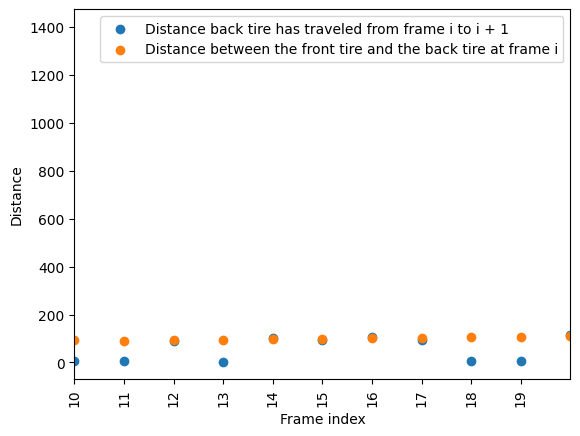

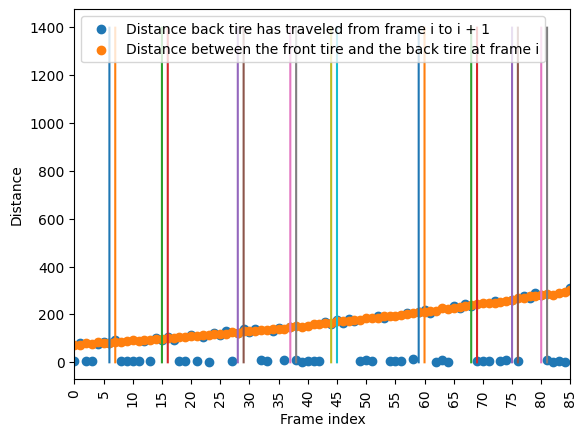

In [10]:
plt.figure()
plt.scatter(range(len(distance_between_each_frame)), distance_between_each_frame, label = "Distance back tire has traveled from frame i to i + 1")
plt.scatter(range(len(tire_pair_distances)), tire_pair_distances, label='Distance between the front tire and the back tire at frame i')
plt.xlabel("Frame index")
plt.xlim(10, 20)
plt.ylabel('Distance')
plt.xticks(np.arange(10, 20, step=1), rotation = 90)
plt.legend()
plt.figure()

plt.scatter(range(len(distance_between_each_frame)), distance_between_each_frame, label = "Distance back tire has traveled from frame i to i + 1")
plt.scatter(range(len(tire_pair_distances)), tire_pair_distances, label='Distance between the front tire and the back tire at frame i')
plt.xlabel("Frame index")
plt.ylabel('Distance')
plt.plot([6 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([7 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([15 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([16 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([28 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([29 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([37 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([38 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([44 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([45 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([59 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([60 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([68 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([69 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([75 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([76 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([80 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([81 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([87 for i in range(0, 1400)], list(range(0, 1400)))
plt.plot([88 for i in range(0, 1400)], list(range(0, 1400)))
plt.xticks(np.arange(0, 150, step=5), rotation = 90)
plt.xlim(0, 85)
plt.legend()

The verticle lines above represent speed is miscalculated. If you look at frame index 15, 16, 17 zoomed out on the top figure, notice that back tire's travel distance is almost equal to the wheel base within one frame in those instance. This did not happen because the vehicle went so fast, but rather because the pixelwise wheelbase distance increases as the vehicle get closer and closer to the camera. So, it adds up the distance the back tire traveled and the error propagated by the fact that vehicle is coming closer to the camera. The possible solution would be to monitor the triangle formed by the camera, back tire and front tire. For now, we just put a band aid here to say that we ignore the instances where the back tire travels a distance equal to the wheelbase distance within a single frame.

In [11]:
data = {"back_tire_x":back_tire_x_list, "back_tire_y":back_tire_y_list, "front_tire_x":front_tire_x_list, "front_tire_y":front_tire_y_list}
df = pd.DataFrame(data)
df.drop(df[df.back_tire_x < 0].index, inplace=True)
df.drop(df[df.front_tire_x < 0].index, inplace=True)
x = df.iloc[:, :-1]
y = df.iloc[:, -1:]

In [12]:
#
model = linear_model.LinearRegression()
model.fit(x, y)
coef = model.coef_[0]
bias = model.intercept_
coef = [
    i + 0.0000001 if i == 0 else i for i in coef
]  # Add a small value to avoid division by zero.
#

In [13]:
back_tire_x_list = []
back_tire_y_list = []
front_tire_x_list = []
front_tire_y_list = []
for i in range(len(data['back_tire_x'])):
    back_tire_x = data['back_tire_x'][i]
    back_tire_y = data['back_tire_y'][i]
    front_tire_x = data['front_tire_x'][i]
    front_tire_y = data['front_tire_y'][i]
    if (back_tire_x < 0 and back_tire_y < 0) and (front_tire_x < 0 and front_tire_y < 0):
        back_tire_x_list.append(back_tire_x)
        back_tire_y_list.append(back_tire_y)
        front_tire_x_list.append(front_tire_x)
        front_tire_y_list.append(front_tire_y)
        continue
    if back_tire_x < 0:
        back_tire_x = (front_tire_y - back_tire_y * coef[1] - front_tire_x* coef[2] - bias)/coef[0]
    if back_tire_y < 0:
        back_tire_y = (front_tire_y - back_tire_x * coef[0] - front_tire_x* coef[2] - bias)/coef[1]
    if front_tire_x < 0:
        front_tire_x = (front_tire_y - back_tire_x * coef[0] - back_tire_y * coef[1] - bias)/coef[2]
    if front_tire_y < 0:
        front_tire_y = back_tire_x * coef[0] + back_tire_y * coef[1] + front_tire_x* coef[2] + bias

    back_tire_x_list.append(back_tire_x)
    back_tire_y_list.append(back_tire_y)
    front_tire_x_list.append(front_tire_x)
    front_tire_y_list.append(front_tire_y)

In [14]:

vehicle_speed = []
skipped = 0

back_tire_keypoints = [back_tire_x_list, back_tire_y_list]
back_tire_keypoints = [list(x) for x in zip(*back_tire_keypoints[::-1])]
front_tire_keypoints = [front_tire_x_list, front_tire_y_list]
front_tire_keypoints = [list(x) for x in zip(*front_tire_keypoints[::-1])]

back_tire_x_list = []
back_tire_y_list = []
front_tire_x_list = []
front_tire_y_list = []
speed_checkpoints = []

approximate_speed = -1
vehicle_speed = {}
for i in range(total_num_points):
    back_tire = back_tire_keypoints[i]
    front_tire = front_tire_keypoints[i]
    if back_tire[0] < 0 or front_tire[0] <0:
        vehicle_speed[i] = approximate_speed
        skipped+=1
        continue
    for j in range(i,total_num_points):
        future_back_tire = back_tire_keypoints[j]
        if future_back_tire[0] < 0:
            continue
        back_tire_x = back_tire[0]
        back_tire_y = back_tire[1]
        front_tire_x = front_tire[0]
        front_tire_y = front_tire[1]
        future_back_tire_x = future_back_tire[0]
        future_back_tire_y = future_back_tire[1]
        current_keypoints_distance = get_distance(back_tire_x, back_tire_y, front_tire_x, front_tire_y)
        future_keypoints_distance = get_distance(back_tire_x, back_tire_y, future_back_tire_x, future_back_tire_y)
        if  (current_keypoints_distance - future_keypoints_distance) >= -DISTANCE_ERROR_THRESHOLD and (current_keypoints_distance - future_keypoints_distance) <= DISTANCE_ERROR_THRESHOLD:
            alpha = get_theta(back_tire_x, back_tire_y, future_back_tire_x, future_back_tire_y)
            beta = get_theta(back_tire_x, back_tire_y, front_tire_x, front_tire_y)
            if  INBETWEENANGLE>=alpha + beta and j - i >1:
                approximate_speed = round(WHEEL_BASE / frames_to_seconds(30, j - i))
                print("Current Speed is", approximate_speed * MPERSTOMPH, "mph",i, j)
                vehicle_speed[i] = round(approximate_speed* MPERSTOMPH)
                back_tire_x_list.append(back_tire_x)
                back_tire_y_list.append(back_tire_y)
                front_tire_x_list.append(front_tire_x)
                front_tire_y_list.append(front_tire_y)
            break
        
    



Current Speed is 8.948 mph 0 19
Current Speed is 8.948 mph 1 19
Current Speed is 11.185 mph 2 17
Current Speed is 11.185 mph 3 17
Current Speed is 4.474 mph 4 42
Current Speed is 8.948 mph 7 26
Current Speed is 11.185 mph 8 22
Current Speed is 4.474 mph 9 49
Current Speed is 11.185 mph 10 25
Current Speed is 4.474 mph 11 51
Current Speed is 11.185 mph 12 27
Current Speed is 6.711 mph 14 35
Current Speed is 6.711 mph 16 38
Current Speed is 11.185 mph 17 32
Current Speed is 6.711 mph 19 42
Current Speed is 6.711 mph 20 45
Current Speed is 11.185 mph 21 37
Current Speed is 4.474 mph 22 69
Current Speed is 6.711 mph 23 47
Current Speed is 2.237 mph 25 76
Current Speed is 2.237 mph 27 81
Current Speed is 6.711 mph 29 55
Current Speed is 8.948 mph 30 48
Current Speed is 2.237 mph 32 90
Current Speed is 2.237 mph 33 92
Current Speed is 2.237 mph 34 94
Current Speed is 6.711 mph 35 64
Current Speed is 2.237 mph 36 98
Current Speed is 4.474 mph 38 69
Current Speed is 4.474 mph 39 70
Current Spe

In [15]:
n_checkpoints = int(len(vehicle_speed))

In [16]:
avg_speed = np.array(list(vehicle_speed.values())).sum()/n_checkpoints

In [17]:
f= open('/code/data/datasets/tracking/predictions/25_resampled_vid/speed_log.json')
speed_log = json.load(f)

In [18]:
algo_preds = speed_log["4"].values()

In [19]:
algo_preds = [ i for i in algo_preds if i > 0]

In [20]:
predicted_avg_speed = np.array(algo_preds).sum()/ len(algo_preds)

In [21]:
print("Percent difference:" , 100*abs(avg_speed - predicted_avg_speed)/ avg_speed, "%")

Percent difference: 54.648124736620325 %
